In [191]:
from datetime import datetime
from operator import le
from os import stat
from re import T
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn import tree, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plants_df = pd.read_excel('../dataset/Data.xlsx', sheet_name='plants')
flights_df = pd.read_excel('../dataset/Data.xlsx', sheet_name='flight dates')
planting_df = pd.read_excel('../dataset/Data.xlsx', sheet_name='planting')
planting_df = planting_df.iloc[:1822 , :]
weather_df = pd.read_excel('../dataset/Data.xlsx', sheet_name='weather')

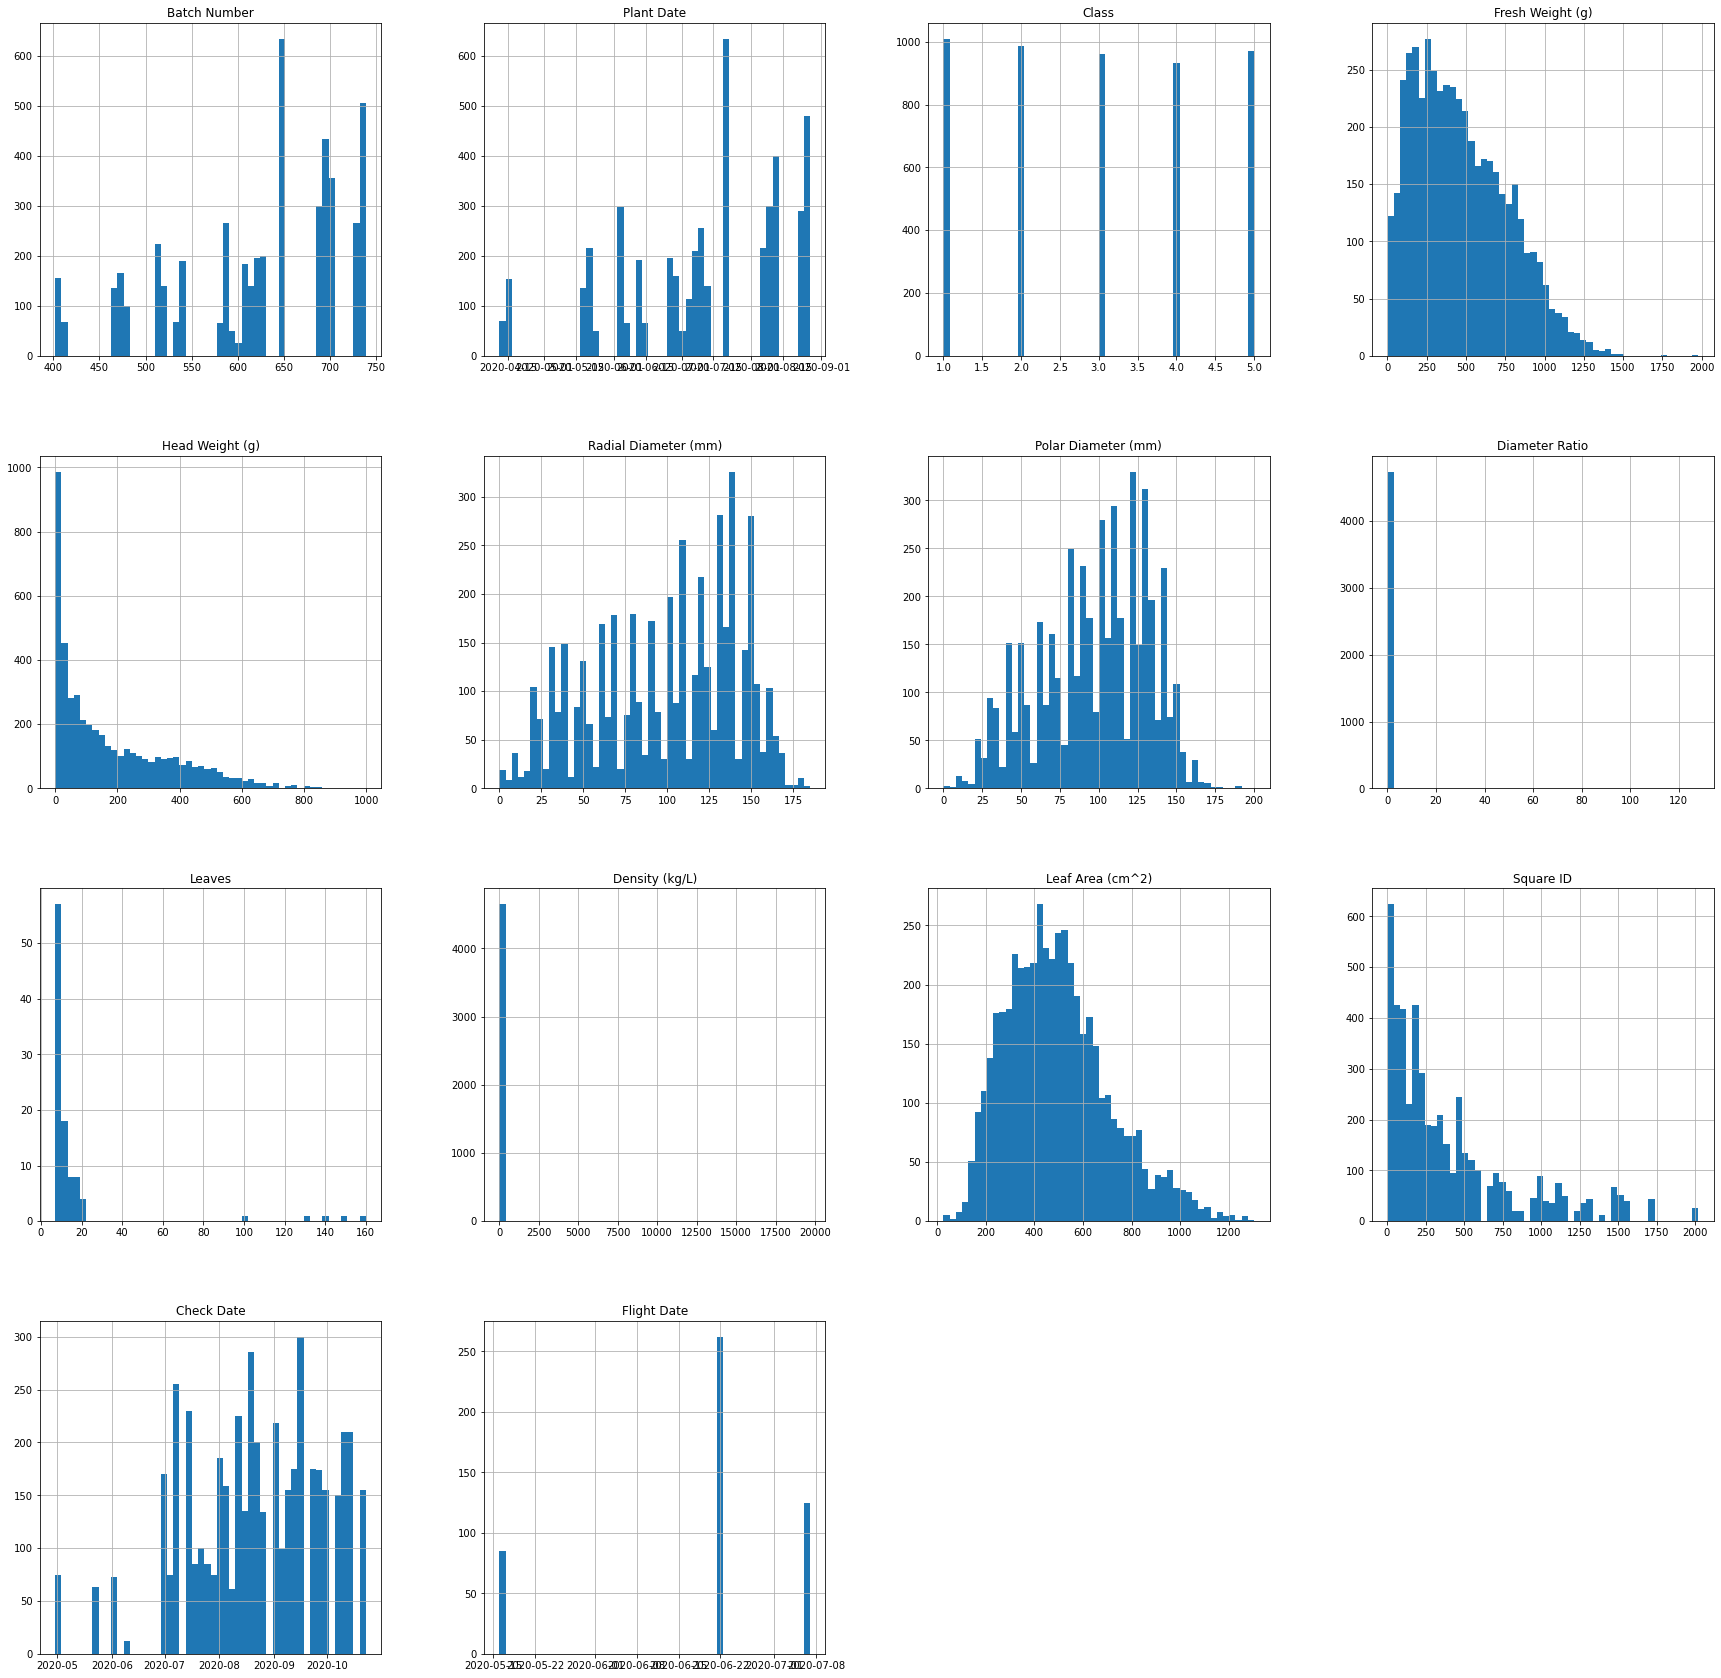

In [224]:
plants_df.hist(bins = 50, figsize=(30,30))
plt.savefig('../plots/plants_hist.pdf', dpi = 120)


In [4]:
plants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Batch Number          4859 non-null   int64         
 1   Plant Date            4685 non-null   datetime64[ns]
 2   Class                 4859 non-null   int64         
 3   Fresh Weight (g)      4858 non-null   float64       
 4   Head Weight (g)       4754 non-null   float64       
 5   Radial Diameter (mm)  4754 non-null   float64       
 6   Polar Diameter (mm)   4754 non-null   float64       
 7   Diameter Ratio        4752 non-null   float64       
 8   Leaves                100 non-null    float64       
 9   Density (kg/L)        4672 non-null   float64       
 10  Leaf Area (cm^2)      4857 non-null   float64       
 11  Square ID             4859 non-null   int64         
 12  Check Date            4859 non-null   datetime64[ns]
 13  Flight Date       

In [5]:
plants_df.describe()

,Batch Number,Class,Fresh Weight (g),Head Weight (g),Radial Diameter (mm),Polar Diameter (mm),Diameter Ratio,Leaves,Density (kg/L),Leaf Area (cm^2),Square ID
count,4859.000000,4859.000000,4858.000000,4754.000000,4754.000000,4754.000000,4752.000000,100.000000,4672.000000,4857.000000,4859.000000
mean,621.778349,2.973040,469.627755,183.349811,99.316996,96.546277,1.037744,17.070000,21.730421,495.275067,403.202099
std,92.932427,1.422882,295.819075,187.242036,42.708981,34.909629,1.881858,28.063512,449.793088,212.659323,416.029674
min,402.000000,1.000000,0.632000,0.000000,0.000000,0.000000,0.050000,7.000000,0.014551,25.000000,4.000000
25%,542.000000,2.000000,229.250000,28.000000,65.000000,70.000000,0.900000,8.000000,0.160685,337.000000,94.000000
50%,647.000000,3.000000,426.000000,115.000000,109.000000,100.000000,1.023859,9.500000,0.216925,471.000000,247.000000
75%,698.000000,4.000000,677.000000,304.000000,135.000000,125.000000,1.142857,12.500000,0.293362,620.000000,529.000000
max,739.000000,5.000000,1978.000000,998.000000,185.000000,200.000000,128.000000,160.000000,19671.550966,1305.000000,2019.000000


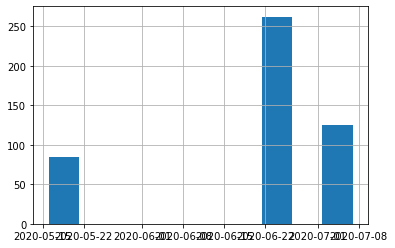

In [6]:
plants_df['Flight Date'].hist()
plt.savefig('../plots/flight_dates_empty.pdf')


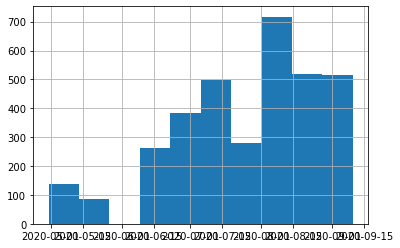

In [7]:
# merge data from plants sheet
df = plants_df.merge(flights_df, on='Batch Number', how='inner').reset_index()

# snippet to fill flight dates
l1 = df['Flight Date_x'].tolist()
l2 = df['Flight Date_y'].tolist()
l3=list()
for cnt, i in enumerate(l1):
    if i is pd.NaT:
        l3.append(l2[cnt])
    else:
        l3.append(i)
df['flight_mod'] = l3
df['flight_mod'].hist()
# df.to_csv('../dataset/plants_flights1.csv')
plt.savefig('../plots/flight_dates.pdf')


In [8]:
# drop the rows for which the plant date is empty
df.dropna(subset=['Plant Date'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3360 entries, 0 to 3379
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 3360 non-null   int64         
 1   Batch Number          3360 non-null   int64         
 2   Plant Date            3360 non-null   datetime64[ns]
 3   Class                 3360 non-null   int64         
 4   Fresh Weight (g)      3359 non-null   float64       
 5   Head Weight (g)       3262 non-null   float64       
 6   Radial Diameter (mm)  3262 non-null   float64       
 7   Polar Diameter (mm)   3262 non-null   float64       
 8   Diameter Ratio        3261 non-null   float64       
 9   Leaves                95 non-null     float64       
 10  Density (kg/L)        3261 non-null   float64       
 11  Leaf Area (cm^2)      3359 non-null   float64       
 12  Square ID             3360 non-null   int64         
 13  Check Date        

In [9]:
planting_df.info()
df_og = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Crop            1821 non-null   object 
 1   Column2         0 non-null      float64
 2   Column3         0 non-null      float64
 3   Plant_Date      1821 non-null   object 
 4   Column1         0 non-null      float64
 5   Region          1821 non-null   float64
 6   Column4         0 non-null      float64
 7   Planting_Batch  1821 non-null   object 
 8   Volume_Planted  1821 non-null   float64
 9   Planting_Wk     1821 non-null   float64
dtypes: float64(7), object(3)
memory usage: 142.5+ KB


In [10]:
df_og = df

In [11]:
# restart point
df = df_og


In [12]:
# split date to day, month and year
df['plant_dates'] = pd.to_datetime(df['Plant Date'])
df['plant_dates_day'] = df['plant_dates'].dt.day
df['plant_dates_month'] = df['plant_dates'].dt.month
df['plant_dates_year'] = df['plant_dates'].dt.year

In [13]:
# create new feature for no of days from plant date to flight date
df['flight_mod'] = pd.to_datetime(df['flight_mod'])
df['plant_dates'] = pd.to_datetime(df['plant_dates'])
df['day_to_check'] = (df['flight_mod'] - df['plant_dates']).dt.days

In [14]:
# split date to day, month and year
df['flight_mod_day'] = df['flight_mod'].dt.day
df['flight_mod_month'] = df['flight_mod'].dt.month
df['flight_mod_year'] = df['flight_mod'].dt.year

In [15]:
#%%
# split date to day, month and year
df['check_date'] = pd.to_datetime(df['Check Date'])
df['check_date_day'] = df['check_date'].dt.day
df['check_date_month'] = df['check_date'].dt.month
df['check_date_year'] = df['check_date'].dt.year

In [16]:
# remove rows that have 'r' in Remove column
df = df[df.Remove != 'r']

Handling weather data

In [17]:
weather_df = pd.read_excel('../dataset/Data.xlsx', sheet_name='weather')

In [18]:
# convert the date to pandas datetime format
weather_df['dates'] = weather_df['Unnamed: 0'].astype(object)
weather_df['dates'] = pd.to_datetime(weather_df['dates'])
# weather_df.info()

# split the date into day, month and year
weather_df['day'] = weather_df['dates'].dt.day
weather_df['month'] = weather_df['dates'].dt.month
weather_df['year'] = weather_df['dates'].dt.year

In [19]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               2556 non-null   datetime64[ns]
 1   Solar Radiation [avg]    2556 non-null   int64         
 2   Precipitation [sum]      2556 non-null   float64       
 3   Wind Speed [avg]         2556 non-null   float64       
 4   Wind Speed [max]         2556 non-null   float64       
 5   Battery Voltage [last]   2556 non-null   int64         
 6   Leaf Wetness [time]      2556 non-null   int64         
 7   Air Temperature [avg]    2556 non-null   float64       
 8   Air Temperature [max]    2556 non-null   float64       
 9   Air Temperature [min]    2556 non-null   float64       
 10  Relative Humidity [avg]  2556 non-null   float64       
 11  Dew Point [avg]          2553 non-null   float64       
 12  Dew Point [min]          2510 non-

In [20]:
names = {'Unnamed: 0':'Date',
        'Solar Radiation [avg]':'Solar_Radiation',
        'Precipitation [sum]':'Precipitation',
        'Wind Speed [avg]':'Wind_Speed_Avg',
        'Wind Speed [max]':'Wind_Speed_Max',
        'Battery Voltage [last]':'Battery Voltage',
        'Leaf Wetness [time]':'Leaf Wetness',
        'Air Temperature [avg]':'Air_Temperature_Avg',
        'Air Temperature [max]':'Air_Temperature_Max',
        'Air Temperature [min]':'Air_Temperature_Min',
        'Relative Humidity [avg]':'Relative Humidity',
        'Dew Point [avg]':'Dew_Point_Avg',
        'Dew Point [min]':'Dew_Point_Min',
        'ET0 [result]':'ET0'}
try:
    weather_df.rename(columns=names,inplace=True)
except:
    pass


In [21]:
weather_df.columns

Index(['Date', 'Solar_Radiation', 'Precipitation', 'Wind_Speed_Avg',
       'Wind_Speed_Max', 'Battery Voltage', 'Leaf Wetness',
       'Air_Temperature_Avg', 'Air_Temperature_Max', 'Air_Temperature_Min',
       'Relative Humidity', 'Dew_Point_Avg', 'Dew_Point_Min', 'ET0', 'dates',
       'day', 'month', 'year'],
      dtype='object')

In [22]:
# replace infinite value with nan and drop such rows
weather_df.replace([np.inf, -np.inf], np.nan, inplace=True)
weather_df.dropna(inplace=True)

# seperate features and target labels, where features are day and month (excluding year)
# and target will be each column in the dataframe which will be individually processed later in the code
# data_X = weather_df.iloc[:,-2:]
# data_y = weather_df.iloc[:,:-2]



In [28]:
def scale_data(data_y):
    transformer = RobustScaler().fit(data_y)
    data_y = transformer.transform(data_y)
    return data_y

## as the mean cv score for date and solar radiation are the only ones that are positive, it would be better to not create weather features from models

In [29]:
# select only those models where the score is acceptable (ie non negative and above 50% )
pd.options.mode.chained_assignment = None # to suppress copy warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
model_list = []
score_list = []
model_dict = {}
i = weather_df
# print(i.shape)
cols = i.columns
col_model_list = []
x = i.iloc[:,-2:]
x = scale_data(x)
for j in cols[:-2]:
    var_name = 'reg_'+str(i)
    i[j].replace([np.inf, -np.inf], np.nan, inplace=True)
    i[j].dropna(inplace=True)
    y = i[j].to_numpy().reshape(-1,1)
    
    y = scale_data(y)
    x, y = shuffle(x, y, random_state=42)
    # print(x.shape, y.shape)
    var_name =  AdaBoostRegressor(random_state= 42)
    scores = cross_val_score(var_name, x, y, cv=5)
    s_m = scores.mean()
    score_list.append(s_m)
    print(f'mean cv score for {j} is {s_m}')
    if s_m >= 0:
        print(f'mean cv scores for column {j} is {s_m}')
        var_name.fit(x, y)
        model_list.append(var_name)
# print(model_list)

mean cv score for Date is 0.9810581429580262
mean cv scores for column Date is 0.9810581429580262
mean cv score for Solar_Radiation is -0.041980930767981796
mean cv score for Precipitation is -1.2020236597768188
mean cv score for Wind_Speed_Avg is -0.09093327262077393
mean cv score for Wind_Speed_Max is -0.08821787376770258
mean cv score for Battery Voltage is -0.22195897000492865
mean cv score for Leaf Wetness is -0.10766310984953872
mean cv score for Air_Temperature_Avg is -0.016524993021925338
mean cv score for Air_Temperature_Max is -0.029298934350583793
mean cv score for Air_Temperature_Min is -0.010350539476255749
mean cv score for Relative Humidity is -0.08147300193296672
mean cv score for Dew_Point_Avg is -0.007244584969584711
mean cv score for Dew_Point_Min is -0.008348450601186741
mean cv score for ET0 is -0.05469098969069086
mean cv score for dates is -0.0064023133453836815
mean cv score for day is -0.011606897651421866


In [30]:
check_date = pd.DataFrame(df["Check Date"].unique(), columns=['Date']) 

In [32]:
# merge weather data with primary dataframe
weather_df.replace([np.inf, -np.inf], np.nan, inplace=True)
weather_df.dropna(inplace=True)
weather_test = pd.merge(
    weather_df,
    check_date
)
weather_train = weather_df[~weather_df["Date"].isin(weather_test["Date"])]

In [33]:
# df.to_csv('tmp.csv')

In [34]:
wet_y = weather_df["ET0"].copy()
wet_x = weather_df.copy().drop(columns = ["ET0", 'Date', 'dates'], axis=1)
wet_x.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2448 entries, 1 to 2554
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar_Radiation      2448 non-null   int64  
 1   Precipitation        2448 non-null   float64
 2   Wind_Speed_Avg       2448 non-null   float64
 3   Wind_Speed_Max       2448 non-null   float64
 4   Battery Voltage      2448 non-null   int64  
 5   Leaf Wetness         2448 non-null   int64  
 6   Air_Temperature_Avg  2448 non-null   float64
 7   Air_Temperature_Max  2448 non-null   float64
 8   Air_Temperature_Min  2448 non-null   float64
 9   Relative Humidity    2448 non-null   float64
 10  Dew_Point_Avg        2448 non-null   float64
 11  Dew_Point_Min        2448 non-null   float64
 12  day                  2448 non-null   int64  
 13  month                2448 non-null   int64  
 14  year                 2448 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 


## As only one feature 'Solar_Radiation' has the highest, it would be better to not create weather features from models as inferred above

Feature 0 Solar_Radiation score: 0.7358792199640884 
Feature 1 Precipitation score: 0.0003085292027727238 
Feature 2 Wind_Speed_Avg score: 0.00919210189428634 
Feature 3 Wind_Speed_Max score: 0.0034610997751156974 
Feature 4 Battery Voltage score: 0.0007300487582918118 
Feature 5 Leaf Wetness score: 9.231264079109502e-05 
Feature 6 Air_Temperature_Avg score: 0.0408709241538509 
Feature 7 Air_Temperature_Max score: 0.060455415974093436 
Feature 8 Air_Temperature_Min score: 0.0027656152268618465 
Feature 9 Relative Humidity score: 0.13877529566804106 
Feature 10 Dew_Point_Avg score: 0.0037451823194895244 
Feature 11 Dew_Point_Min score: 0.0003184345884650627 
Feature 12 day score: 0.0003742594307509143 
Feature 13 month score: 0.002400107277443225 
Feature 14 year score: 0.0006314531256579767 


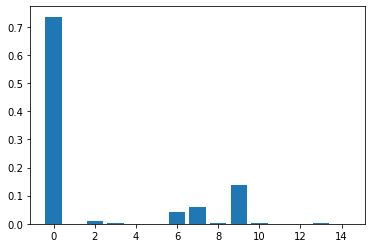

In [35]:
wet_x_feature_list = wet_x.columns.to_numpy()

# split the data
wet_x_train, wet_x_test, wet_y_train, wet_y_test = train_test_split(
    wet_x, wet_y, test_size=0.2, random_state=42)

wet_x_train, wet_x_val, wet_y_train, wet_y_val = train_test_split(
    wet_x_train, wet_y_train, test_size=0.2, random_state=42)

# Normalise data
wet_scaler = RobustScaler()
wet_x_train = wet_scaler.fit_transform(wet_x_train)
wet_x_test = wet_scaler.transform(wet_x_test)
model = GradientBoostingRegressor() 

# fit the model
model.fit(wet_x_train, wet_y_train)

importance = model.feature_importances_
# plot feature importance
for i,v in enumerate(importance):
    # print('Feature {0}: {1}, Score: {2:.5f}' .format(i,wet_x_feature_list[i],v))
    print(f'Feature {i} {wet_x_feature_list[i]} score: {v} ')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [116]:
df_wet = df

In [36]:
weather_df.columns

Index(['Date', 'Solar_Radiation', 'Precipitation', 'Wind_Speed_Avg',
       'Wind_Speed_Max', 'Battery Voltage', 'Leaf Wetness',
       'Air_Temperature_Avg', 'Air_Temperature_Max', 'Air_Temperature_Min',
       'Relative Humidity', 'Dew_Point_Avg', 'Dew_Point_Min', 'ET0', 'dates',
       'day', 'month', 'year'],
      dtype='object')

In [37]:
df.columns

Index(['index', 'Batch Number', 'Plant Date', 'Class', 'Fresh Weight (g)',
       'Head Weight (g)', 'Radial Diameter (mm)', 'Polar Diameter (mm)',
       'Diameter Ratio', 'Leaves', 'Density (kg/L)', 'Leaf Area (cm^2)',
       'Square ID', 'Check Date', 'Flight Date_x', 'Remove', 'Flight Date_y',
       'flight_mod', 'plant_dates', 'plant_dates_day', 'plant_dates_month',
       'plant_dates_year', 'day_to_check', 'flight_mod_day',
       'flight_mod_month', 'flight_mod_year', 'check_date', 'check_date_day',
       'check_date_month', 'check_date_year'],
      dtype='object')

In [38]:
df_wet = weather_df.merge(df, left_on='Date', right_on = 'Plant Date', how='inner').reset_index()

In [39]:
# remove non numeric columns
drop_list = df_wet.select_dtypes(exclude=np.number).columns.tolist()
df_wet_mod = df_wet.drop(columns=drop_list)
drop_list

['Date',
 'dates',
 'Plant Date',
 'Check Date',
 'Flight Date_x',
 'Remove',
 'Flight Date_y',
 'flight_mod',
 'plant_dates',
 'check_date']

In [40]:
df_wet_mod.dtypes

level_0                   int64
Solar_Radiation           int64
Precipitation           float64
Wind_Speed_Avg          float64
Wind_Speed_Max          float64
Battery Voltage           int64
Leaf Wetness              int64
Air_Temperature_Avg     float64
Air_Temperature_Max     float64
Air_Temperature_Min     float64
Relative Humidity       float64
Dew_Point_Avg           float64
Dew_Point_Min           float64
ET0                     float64
day                       int64
month                     int64
year                      int64
index                     int64
Batch Number              int64
Class                     int64
Fresh Weight (g)        float64
Head Weight (g)         float64
Radial Diameter (mm)    float64
Polar Diameter (mm)     float64
Diameter Ratio          float64
Leaves                  float64
Density (kg/L)          float64
Leaf Area (cm^2)        float64
Square ID                 int64
plant_dates_day           int64
plant_dates_month         int64
plant_da

In [41]:
names = {'Unnamed: 0':'Date',
        'Solar Radiation [avg]':'Solar_Radiation',
        'Precipitation [sum]':'Precipitation',
        'Wind Speed [avg]':'Wind_Speed_Avg',
        'Wind Speed [max]':'Wind_Speed_Max',
        'Battery Voltage [last]':'Battery Voltage',
        'Leaf Wetness [time]':'Leaf Wetness',
        'Air Temperature [avg]':'Air_Temperature_Avg',
        'Air Temperature [max]':'Air_Temperature_Max',
        'Air Temperature [min]':'Air_Temperature_Min',
        'Relative Humidity [avg]':'Relative Humidity',
        'Dew Point [avg]':'Dew_Point_Avg',
        'Dew Point [min]':'Dew_Point_Min',
        'ET0 [result]':'ET0'}
try:
    df_wet_mod.rename(columns=names,inplace=True)
except:
    pass

In [42]:
df_wet_mod.head()

,level_0,Solar_Radiation,Precipitation,Wind_Speed_Avg,Wind_Speed_Max,Battery Voltage,Leaf Wetness,Air_Temperature_Avg,Air_Temperature_Max,Air_Temperature_Min,...,plant_dates_day,plant_dates_month,plant_dates_year,day_to_check,flight_mod_day,flight_mod_month,flight_mod_year,check_date_day,check_date_month,check_date_year
0,0,251,0.0,1.4,4.5,6884,0,14.75,24.45,4.42,...,11,4,2020,19,30,4,2020,30,4,2020
1,1,251,0.0,1.4,4.5,6884,0,14.75,24.45,4.42,...,11,4,2020,19,30,4,2020,30,4,2020
2,2,251,0.0,1.4,4.5,6884,0,14.75,24.45,4.42,...,11,4,2020,19,30,4,2020,30,4,2020
3,3,251,0.0,1.4,4.5,6884,0,14.75,24.45,4.42,...,11,4,2020,19,30,4,2020,30,4,2020
4,4,251,0.0,1.4,4.5,6884,0,14.75,24.45,4.42,...,11,4,2020,19,30,4,2020,30,4,2020


In [44]:

# df.to_csv('../dataset/tmp4_1.csv')
# as leaves column has a lot of null values, dropping the column would be a better approach than imputing with limited data as it will introduce noise
# Leaves
# try:
df_wet_mod.drop(columns=['Leaves', 'level_0'], inplace= True)
# except:
#     pass
# df_wet_mod.to_csv('tmp4_1.csv')

In [207]:
xtrain_notnull = df_wet_mod.loc[df_wet_mod['Radial Diameter (mm)'].notnull(), df_wet_mod.columns]
xtrain_notnull.dropna(subset=['Polar Diameter (mm)', 'Diameter Ratio'], inplace=True)

# xtrain_notnull.drop(columns=['Leaves','Flight Date_x','Flight Date_y','Remove'], inplace=True)
xtrain_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 25 to 3293
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Solar_Radiation       3195 non-null   int64  
 1   Precipitation         3195 non-null   float64
 2   Wind_Speed_Avg        3195 non-null   float64
 3   Wind_Speed_Max        3195 non-null   float64
 4   Battery Voltage       3195 non-null   int64  
 5   Leaf Wetness          3195 non-null   int64  
 6   Air_Temperature_Avg   3195 non-null   float64
 7   Air_Temperature_Max   3195 non-null   float64
 8   Air_Temperature_Min   3195 non-null   float64
 9   Relative Humidity     3195 non-null   float64
 10  Dew_Point_Avg         3195 non-null   float64
 11  Dew_Point_Min         3195 non-null   float64
 12  ET0                   3195 non-null   float64
 13  day                   3195 non-null   int64  
 14  month                 3195 non-null   int64  
 15  year                

In [208]:
# Create correlation matrix
corr_matrix = xtrain_notnull.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# corr_matrix
to_drop

['Dew_Point_Min', 'Batch Number', 'plant_dates_day', 'plant_dates_month']

In [209]:
xtrain_notnull.columns

Index(['Solar_Radiation', 'Precipitation', 'Wind_Speed_Avg', 'Wind_Speed_Max',
       'Battery Voltage', 'Leaf Wetness', 'Air_Temperature_Avg',
       'Air_Temperature_Max', 'Air_Temperature_Min', 'Relative Humidity',
       'Dew_Point_Avg', 'Dew_Point_Min', 'ET0', 'day', 'month', 'year',
       'index', 'Batch Number', 'Class', 'Fresh Weight (g)', 'Head Weight (g)',
       'Radial Diameter (mm)', 'Polar Diameter (mm)', 'Diameter Ratio',
       'Density (kg/L)', 'Leaf Area (cm^2)', 'Square ID', 'plant_dates_day',
       'plant_dates_month', 'plant_dates_year', 'day_to_check',
       'flight_mod_day', 'flight_mod_month', 'flight_mod_year',
       'check_date_day', 'check_date_month', 'check_date_year'],
      dtype='object')

In [210]:
# remove highly co related columns
xtrain_notnull.drop(columns=to_drop, inplace=True)

# remove irrelevant or redundant columns
xtrain_notnull.drop(columns=['Wind_Speed_Max', 'Battery Voltage', 'Air_Temperature_Max', 'Air_Temperature_Min',
'ET0', 'index', 'Square ID'], inplace=True)

In [211]:
xtrain_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 25 to 3293
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Solar_Radiation       3195 non-null   int64  
 1   Precipitation         3195 non-null   float64
 2   Wind_Speed_Avg        3195 non-null   float64
 3   Leaf Wetness          3195 non-null   int64  
 4   Air_Temperature_Avg   3195 non-null   float64
 5   Relative Humidity     3195 non-null   float64
 6   Dew_Point_Avg         3195 non-null   float64
 7   day                   3195 non-null   int64  
 8   month                 3195 non-null   int64  
 9   year                  3195 non-null   int64  
 10  Class                 3195 non-null   int64  
 11  Fresh Weight (g)      3195 non-null   float64
 12  Head Weight (g)       3195 non-null   float64
 13  Radial Diameter (mm)  3195 non-null   float64
 14  Polar Diameter (mm)   3195 non-null   float64
 15  Diameter Ratio      

In [212]:
# create a dataframe of non missing values of 'Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)'
df_x_non_empty = xtrain_notnull.loc[xtrain_notnull['Head Weight (g)'].notnull(), xtrain_notnull.columns]
df_x_non_empty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 25 to 3293
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Solar_Radiation       3195 non-null   int64  
 1   Precipitation         3195 non-null   float64
 2   Wind_Speed_Avg        3195 non-null   float64
 3   Leaf Wetness          3195 non-null   int64  
 4   Air_Temperature_Avg   3195 non-null   float64
 5   Relative Humidity     3195 non-null   float64
 6   Dew_Point_Avg         3195 non-null   float64
 7   day                   3195 non-null   int64  
 8   month                 3195 non-null   int64  
 9   year                  3195 non-null   int64  
 10  Class                 3195 non-null   int64  
 11  Fresh Weight (g)      3195 non-null   float64
 12  Head Weight (g)       3195 non-null   float64
 13  Radial Diameter (mm)  3195 non-null   float64
 14  Polar Diameter (mm)   3195 non-null   float64
 15  Diameter Ratio      

In [213]:
# create a dataframe of missing values of 'Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)'
df_x_empty = df_wet_mod.loc[df_wet_mod['Head Weight (g)'].isnull(), df_wet_mod.columns]
df_x_empty.drop(columns=['Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)',
'Head Weight (g)', 'Diameter Ratio', 'Density (kg/L)'])
df_x_empty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 1138
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Solar_Radiation       98 non-null     int64  
 1   Precipitation         98 non-null     float64
 2   Wind_Speed_Avg        98 non-null     float64
 3   Wind_Speed_Max        98 non-null     float64
 4   Battery Voltage       98 non-null     int64  
 5   Leaf Wetness          98 non-null     int64  
 6   Air_Temperature_Avg   98 non-null     float64
 7   Air_Temperature_Max   98 non-null     float64
 8   Air_Temperature_Min   98 non-null     float64
 9   Relative Humidity     98 non-null     float64
 10  Dew_Point_Avg         98 non-null     float64
 11  Dew_Point_Min         98 non-null     float64
 12  ET0                   98 non-null     float64
 13  day                   98 non-null     int64  
 14  month                 98 non-null     int64  
 15  year                  9

In [214]:
# get targets for multi label regression
df_y = df_x_non_empty[['Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)']].copy()
# df_x = df_x_non_empty.drop(columns= ['Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)'])

# remove columns mentioned in data description
df_x = df_x_non_empty.drop(columns=['Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)',
'Diameter Ratio', 'Density (kg/L)'])

In [215]:
df_x_feature_list = df_x.columns.to_numpy()

# split the data
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, df_y, test_size=0.2, random_state=42, shuffle=True)

In [170]:
df_x_train.shape, df_y_train.shape

((2044, 21), (2044, 3))

In [171]:
print((df_x_train.columns))
print(df_y_train.columns)

Index(['Solar_Radiation', 'Precipitation', 'Wind_Speed_Avg', 'Leaf Wetness',
       'Air_Temperature_Avg', 'Relative Humidity', 'Dew_Point_Avg', 'day',
       'month', 'year', 'Class', 'Fresh Weight (g)', 'Leaf Area (cm^2)',
       'plant_dates_year', 'day_to_check', 'flight_mod_day',
       'flight_mod_month', 'flight_mod_year', 'check_date_day',
       'check_date_month', 'check_date_year'],
      dtype='object')
Index(['Head Weight (g)', 'Polar Diameter (mm)', 'Radial Diameter (mm)'], dtype='object')


In [227]:
df_y_train.describe()

,Head Weight (g),Polar Diameter (mm),Radial Diameter (mm)
count,2556.000000,2556.000000,2556.000000
mean,235.078247,102.728482,110.475743
std,200.549752,33.725666,41.317716
min,1.000000,10.000000,10.000000
25%,47.000000,80.000000,80.000000
50%,203.000000,110.000000,125.000000
75%,383.000000,130.000000,141.000000
max,946.000000,178.000000,185.000000


(2044, 21) (2044, 1)
Feature 0: Solar_Radiation, Score: 0.00066
Feature 1: Precipitation, Score: 0.00086
Feature 2: Wind_Speed_Avg, Score: 0.01110
Feature 3: Leaf Wetness, Score: 0.00392
Feature 4: Air_Temperature_Avg, Score: 0.02285
Feature 5: Relative Humidity, Score: 0.01135
Feature 6: Dew_Point_Avg, Score: 0.00949
Feature 7: day, Score: 0.00165
Feature 8: month, Score: 0.01439
Feature 9: year, Score: 0.00000
Feature 10: Class, Score: 0.00039
Feature 11: Fresh Weight (g), Score: 0.82498
Feature 12: Leaf Area (cm^2), Score: 0.00855
Feature 13: plant_dates_year, Score: 0.00000
Feature 14: day_to_check, Score: 0.03318
Feature 15: flight_mod_day, Score: 0.03222
Feature 16: flight_mod_month, Score: 0.00926
Feature 17: flight_mod_year, Score: 0.00000
Feature 18: check_date_day, Score: 0.01096
Feature 19: check_date_month, Score: 0.00420
Feature 20: check_date_year, Score: 0.00000


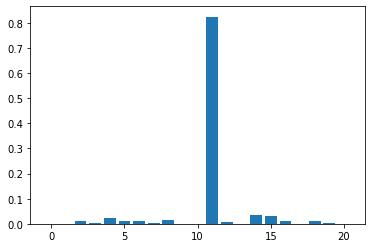

In [172]:
# Normalise data
wet_x_feature_list = df_x_train.columns.to_numpy()

df_tmp_y = df_y_train['Polar Diameter (mm)'].to_numpy().reshape(-1,1)
wet_scaler = RobustScaler()
df_x_train_tmp = wet_scaler.fit_transform(df_x_train)
model = GradientBoostingRegressor()
print(df_x_train_tmp.shape,df_tmp_y.shape)
# fit the model
model.fit(df_x_train_tmp, df_tmp_y)

importance = model.feature_importances_
# plot feature importance
for i,v in enumerate(importance):
    print('Feature {0}: {1}, Score: {2:.5f}' .format(i,wet_x_feature_list[i],v))
    # print(f'Feature {i} {wet_x_feature_list[i]} score: {v} ')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [173]:
# Create correlation matrix
corr_matrix = df_x_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# corr_matrix
to_drop

[]

# Model creation 

In [189]:
dmr = MultiOutputRegressor(DummyRegressor(strategy="mean")).fit(df_x_train,df_y_train)
dmr_pred = dmr.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, dmr_pred))
print('R2:',r2_score(df_y_test, dmr_pred))

MSE: 14628.058334157993
R2: -0.0014616284462395008


In [195]:
# create SVM (regressor) model
svm_model = MultiOutputRegressor(svm.SVR())
grid_search_params = {'estimator__C': np.logspace(-1, 3, 9),  
              'estimator__gamma': np.logspace(-7, 7, 12)}

svm_gridsearch = GridSearchCV(svm_model,grid_search_params,n_jobs=-1, cv = 10)
svm_gridsearch.fit(df_x_train,df_y_train)

print(f"Best parameters: {svm_gridsearch.best_params_}")
print(f"Best score : {svm_gridsearch.best_score_}")

# create new SVR model with best parameters from grid search
svm_model_cv = MultiOutputRegressor(svm.SVR(C = svm_gridsearch.best_params_['estimator__C'],
                                    gamma=svm_gridsearch.best_params_['estimator__gamma']))

# compute the R2 scores on the test set
svm_model_cv.fit(df_x_train,df_y_train)
svm_pred = svm_model_cv.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, svm_pred))
print('R2:',r2_score(df_y_test, svm_pred))

Best parameters: {'estimator__C': 1000.0, 'estimator__gamma': 3.511191734215127e-05}
Best score : 0.8875048543552906
MSE: 1342.8742771954073
R2: 0.8755525933718756


In [229]:
abreg = MultiOutputRegressor(AdaBoostRegressor(random_state=42))
# print(abreg.get_params().keys())
params = {
 'estimator__n_estimators':  [40,60,80,100,120],
 'estimator__learning_rate' : [0.05, 0.02, 0.1, 0.5],
 'estimator__loss' : ['linear', 'square']
 }

gridsearch = GridSearchCV(abreg, params, cv=10, return_train_score=True)
gridsearch.fit(df_x_train, df_y_train)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

best_estim=gridsearch.best_estimator_
print(best_estim)

# adaboost model with best params from grid search
abreg_best = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.5,
                                                 n_estimators=100,
                                                 random_state=42))

abreg_best.fit(df_x_train,df_y_train)
abred_preds=abreg_best.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, abred_preds))
print('R2:',r2_score(df_y_test, abred_preds))

{'estimator__learning_rate': 0.5, 'estimator__loss': 'linear', 'estimator__n_estimators': 40}
0.8592222831202296
MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.5,
                                                 n_estimators=40,
                                                 random_state=42))
MSE: 1020.598127188333
R2: 0.9068811931136292


In [230]:
# ensemble model with voting using models with default hyperparameters
reg2 = RandomForestRegressor()
reg3 = LinearRegression()
reg4 = tree.DecisionTreeRegressor()
ereg = MultiOutputRegressor(VotingRegressor(estimators=[('dt', reg4), ('rf', reg2), ('lr', reg3)]))
ereg = ereg.fit(df_x_train, df_y_train)

scores = cross_val_score(ereg, df_x_train, df_y_train, cv=10)
print(max(scores))
ereg_pred = ereg.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, ereg_pred))
print('R2:',r2_score(df_y_test, ereg_pred))

0.916355325944496
MSE: 1224.999808487142
R2: 0.8966248481905023


In [231]:
# Decision tree using grid search and cross validation
tree_model = MultiOutputRegressor(tree.DecisionTreeRegressor(random_state=1234))
param_grid = {
    'estimator__max_depth': np.arange(2,10),
    'estimator__min_samples_split': np.arange(2,10),
    'estimator__min_samples_leaf': np.arange(2,10)}
tree_gridcv = GridSearchCV(tree_model,param_grid,cv=10 ,n_jobs=-1)
tree_gridcv.fit(df_x_train,df_y_train)

print(f"Best parameters:  {tree_gridcv.best_params_}")
print(f"Best score:  {tree_gridcv.best_score_}")

# scores for the decision tree
# tree_model_score = tree_gridcv.score(test_X, test_Y)
# print(f'non pruned {tree_model_score}')


# create new decision tree model with best parameters from grid search
tree_model_prunned = tree.DecisionTreeRegressor(random_state=1234,
                                               max_depth= tree_gridcv.best_params_['estimator__max_depth'],
                                               min_samples_leaf= tree_gridcv.best_params_['estimator__min_samples_leaf'],
                                               min_samples_split=tree_gridcv.best_params_['estimator__min_samples_split'] )

tree_model_prunned.fit(df_x_train,df_y_train)

tree_pred = tree_model_prunned.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, tree_pred))
print('R2:',r2_score(df_y_test, ereg_pred))

Best parameters:  {'estimator__max_depth': 8, 'estimator__min_samples_leaf': 9, 'estimator__min_samples_split': 2}
Best score:  0.8897321344475222
MSE: 1378.6482868230858
R2: 0.8966248481905023


In [233]:
# create Linear regression model
lr1 = MultiOutputRegressor(LinearRegression()).fit(df_x_train,df_y_train)
lr_pred = lr1.predict(df_x_test)
scores = cross_val_score(lr1, df_x_train, df_y_train, cv=10)
print(max(scores))
print('MSE:', mean_squared_error(df_y_test, lr_pred))
print('R2:',r2_score(df_y_test, lr_pred))

0.8511283812381988
MSE: 2059.7591558413274
R2: 0.813747632708259


## using scaled data

In [234]:
df_x_test = wet_scaler.fit_transform(df_x_test)
df_x_train = wet_scaler.fit_transform(df_x_train)

# Model creation 
dmr = MultiOutputRegressor(DummyRegressor(strategy="mean")).fit(df_x_train,df_y_train)
dmr_pred = dmr.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, dmr_pred))
print('R2:',r2_score(df_y_test, dmr_pred))


MSE: 14630.89521581468
R2: -0.0016434474316380232


In [235]:
# create SVM (regressor) model
svm_model = MultiOutputRegressor(svm.SVR())
grid_search_params = {'estimator__C': np.logspace(-1, 3, 9),  
              'estimator__gamma': np.logspace(-7, 7, 12)}

svm_gridsearch = GridSearchCV(svm_model,grid_search_params,n_jobs=-1, cv = 10)
svm_gridsearch.fit(df_x_train,df_y_train)

print(f"Best parameters: {svm_gridsearch.best_params_}")
print(f"Best score : {svm_gridsearch.best_score_}")

# create new SVR model with best parameters from grid search
svm_model_cv = MultiOutputRegressor(svm.SVR(C = svm_gridsearch.best_params_['estimator__C'],
                                    gamma=svm_gridsearch.best_params_['estimator__gamma']))

# compute the R2 scores on the test set
svm_model_cv.fit(df_x_train,df_y_train)
svm_pred = svm_model_cv.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, svm_pred))
print('R2:',r2_score(df_y_test, svm_pred))




Best parameters: {'estimator__C': 316.22776601683796, 'estimator__gamma': 0.2310129700083158}
Best score : 0.9111423875389134
MSE: 1498.1620169272799
R2: 0.8747548529810615


In [237]:
abreg = MultiOutputRegressor(AdaBoostRegressor(random_state=42))
# print(abreg.get_params().keys())
params = {
 'estimator__n_estimators':  [40,60,80,100,120],
 'estimator__learning_rate' : [0.05, 0.02, 0.1, 0.5],
 'estimator__loss' : ['linear', 'square']
 }

gridsearch = GridSearchCV(abreg, params, cv=10, return_train_score=True)
gridsearch.fit(df_x_train, df_y_train)
print(gridsearch.best_params_)
print(gridsearch.best_score_)


best_estim=gridsearch.best_estimator_
print(best_estim)

# adaboost model with best params from grid search
abreg_best = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.5,
                                                 n_estimators=100,
                                                 random_state=42))

abreg_best.fit(df_x_train,df_y_train)
abred_preds=abreg_best.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, abred_preds))
print('R2:',r2_score(df_y_test, abred_preds))


KeyboardInterrupt: 

In [ ]:
# ensemble model with voting using models with default hyperparameters
reg2 = RandomForestRegressor()
reg3 = LinearRegression()
reg4 = tree.DecisionTreeRegressor()
ereg = MultiOutputRegressor(VotingRegressor(estimators=[('dt', reg4), ('rf', reg2), ('lr', reg3)]))
# ereg = ereg.fit(df_x_train, df_y_train)
scores = cross_val_score(ereg, df_x_train, df_y_train, cv=10)
print(max(scores))
ereg = ereg.fit(df_x_train, df_y_train)

ereg_pred = ereg.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, ereg_pred))
print('R2:',r2_score(df_y_test, ereg_pred))


In [ ]:
# Decision tree using grid search and cross validation
tree_model = MultiOutputRegressor(tree.DecisionTreeRegressor(random_state=1234))
param_grid = {
    'estimator__max_depth': np.arange(2,10),
    'estimator__min_samples_split': np.arange(2,10),
    'estimator__min_samples_leaf': np.arange(2,10)}
tree_gridcv = GridSearchCV(tree_model,param_grid,cv=10 ,n_jobs=-1)
tree_gridcv.fit(df_x_train,df_y_train)

print(f"Best parameters:  {tree_gridcv.best_params_}")
print(f"Best score:  {tree_gridcv.best_score_}")

# scores for the decision tree
# tree_model_score = tree_gridcv.score(test_X, test_Y)
# print(f'non pruned {tree_model_score}')


# create new decision tree model with best parameters from grid search
tree_model_prunned = tree.DecisionTreeRegressor(random_state=1234,
                                               max_depth= tree_gridcv.best_params_['estimator__max_depth'],
                                               min_samples_leaf= tree_gridcv.best_params_['estimator__min_samples_leaf'],
                                               min_samples_split=tree_gridcv.best_params_['estimator__min_samples_split'] )

tree_model_prunned.fit(df_x_train,df_y_train)

tree_pred = tree_model_prunned.predict(df_x_test)
print('MSE:', mean_squared_error(df_y_test, tree_pred))
print('R2:',r2_score(df_y_test, ereg_pred))


In [ ]:
# create Linear regression model
lr1 = MultiOutputRegressor(LinearRegression()).fit(df_x_train,df_y_train)
scores = cross_val_score(lr1, df_x_train, df_y_train, cv=10)
print(max(scores))
lr_pred = lr1.predict(df_x_test)

print('MSE:', mean_squared_error(df_y_test, lr_pred))
print('R2:',r2_score(df_y_test, lr_pred))

MSE: 694606.2401173967
R2: -91.01170432311854


In [216]:
df_x_train.columns

Index(['Solar_Radiation', 'Precipitation', 'Wind_Speed_Avg', 'Leaf Wetness',
       'Air_Temperature_Avg', 'Relative Humidity', 'Dew_Point_Avg', 'day',
       'month', 'year', 'Class', 'Fresh Weight (g)', 'Leaf Area (cm^2)',
       'plant_dates_year', 'day_to_check', 'flight_mod_day',
       'flight_mod_month', 'flight_mod_year', 'check_date_day',
       'check_date_month', 'check_date_year'],
      dtype='object')

In [221]:
rslt_df = df_x_train.loc[df_x_train['year'] < 2020]
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 611 to 3273
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar_Radiation      2556 non-null   int64  
 1   Precipitation        2556 non-null   float64
 2   Wind_Speed_Avg       2556 non-null   float64
 3   Leaf Wetness         2556 non-null   int64  
 4   Air_Temperature_Avg  2556 non-null   float64
 5   Relative Humidity    2556 non-null   float64
 6   Dew_Point_Avg        2556 non-null   float64
 7   day                  2556 non-null   int64  
 8   month                2556 non-null   int64  
 9   year                 2556 non-null   int64  
 10  Class                2556 non-null   int64  
 11  Fresh Weight (g)     2556 non-null   float64
 12  Leaf Area (cm^2)     2556 non-null   float64
 13  plant_dates_year     2556 non-null   int64  
 14  day_to_check         2556 non-null   int64  
 15  flight_mod_day       2556 non-null  

In [220]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 611 to 3273
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar_Radiation      2556 non-null   int64  
 1   Precipitation        2556 non-null   float64
 2   Wind_Speed_Avg       2556 non-null   float64
 3   Leaf Wetness         2556 non-null   int64  
 4   Air_Temperature_Avg  2556 non-null   float64
 5   Relative Humidity    2556 non-null   float64
 6   Dew_Point_Avg        2556 non-null   float64
 7   day                  2556 non-null   int64  
 8   month                2556 non-null   int64  
 9   year                 2556 non-null   int64  
 10  Class                2556 non-null   int64  
 11  Fresh Weight (g)     2556 non-null   float64
 12  Leaf Area (cm^2)     2556 non-null   float64
 13  plant_dates_year     2556 non-null   int64  
 14  day_to_check         2556 non-null   int64  
 15  flight_mod_day       2556 non-null  

In [222]:
df_x_train.to_csv('yer.csv')